# 📊 Tarea de Regresión Lineal

**Estudiante:** Diego Miranda  
**Conjunto de Datos:** *Car price prediction*
**Fuente del Dataset:** [Manish Kumar - Kaggle](https://www.kaggle.com/datasets/hellbuoy/car-price-prediction)
---

In [36]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import seaborn as sns
import plotly.express as px

# Análisis
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
import pingouin as pg  # Para correlación parcial

import gc
import pingouin as pg
# Estilo


sns.set(style="whitegrid")

In [49]:
df = pd.read_csv("datasets/CarPrice_Assignment.csv", sep=',',index_col='car_ID') # ,index_col='CarName'
print("Shape: ", df.shape)
print("Dtypes: ", df.dtypes)
df.head()

Shape:  (205, 25)
Dtypes:  symboling             int64
CarName              object
fueltype             object
aspiration           object
doornumber           object
carbody              object
drivewheel           object
enginelocation       object
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype           object
cylindernumber       object
enginesize            int64
fuelsystem           object
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
price               float64
dtype: object


,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
car_ID,,,,,,,,,,,,,,,,,,,,,
1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [57]:
print(df.loc[df['CarName'] == 'alfa-romero giulia', 'price'])

car_ID
1    13495.0
Name: price, dtype: float64


In [38]:
df['brand'] = (
    df['CarName']            # alfa-romero giulia, audi 100 ls, …
      .str.split()           # -> ['alfa-romero', 'giulia']
      .str[0]                # -> 'alfa-romero'
      .str.lower()           # homogeniza mayúsculas/minúsculas
)
correction_dict = {
    'alfa-romero': 'alfa-romeo',
    'maxda': 'mazda',
    'Nissan': 'nissan',
    'porcshce': 'porsche',
    'toyouta': 'toyota',
    'vokswagen': 'volkswagen',
    'vw': 'volkswagen'
}
df['brand'] = df['brand'].replace(correction_dict)
print(df['brand'].value_counts())

brand
toyota        32
nissan        18
mazda         17
mitsubishi    13
honda         13
subaru        12
volkswagen    12
volvo         11
peugeot       11
dodge          9
buick          8
bmw            8
audi           7
plymouth       7
saab           6
porsche        5
isuzu          4
alfa-romeo     3
chevrolet      3
jaguar         3
renault        2
mercury        1
Name: count, dtype: int64


In [39]:
marca = df.loc[df['enginetype'] == 'rotor', 'brand']
df['logprice'] = np.log(df['price'])
marca

car_ID
56    mazda
57    mazda
58    mazda
59    mazda
Name: brand, dtype: object

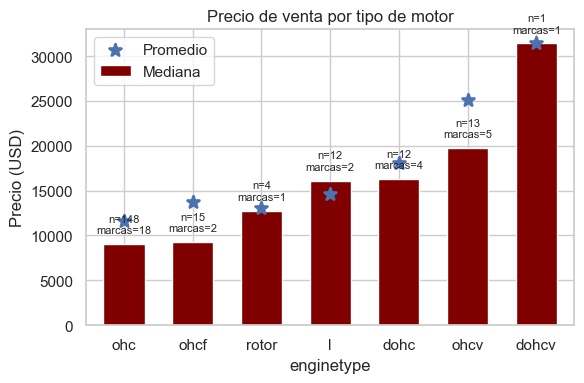


=== ANOVA: efecto de engine_type sobre price ===
                  sum_sq     df         F        PR(>F)
C(enginetype)  11.079503    6.0  8.983444  1.106730e-08
Residual       40.699714  198.0       NaN           NaN


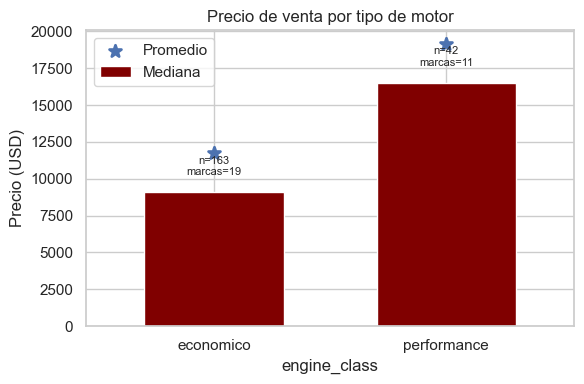


=== ANOVA: efecto de engine_class sobre price ===
                    sum_sq     df          F        PR(>F)
C(engine_class)   8.758301    1.0  41.327226  9.023544e-10
Residual         43.020916  203.0        NaN           NaN


12245

In [40]:
from statsmodels.formula.api import ols


def plot_engine_price(grouped_df, suffix=''):
    plt.figure(figsize=(6, 4))
    ax = grouped_df['median'].plot(kind='bar',
                                   color='maroon',
                                   width=0.6,
                                   label='Mediana')
    ax.scatter(x=np.arange(len(grouped_df)),
               y=grouped_df['mean'],
               marker='*',
               s=80,
               linewidths=2,
               label='Promedio',
               zorder=3)
    # Etiquetas: n de autos y n de marcas
    for idx, (med, n, nb) in enumerate(zip(grouped_df['median'],
                                           grouped_df['count'],
                                           grouped_df['brand_count'])):
        ax.text(idx,
                med + 1000,          
                f'n={n}\nmarcas={nb}',
                ha='center',
                va='bottom',
                fontsize=8)

    plt.ylabel('Precio (USD)')
    plt.title('Precio de venta por tipo de motor')
    plt.xticks(rotation=0)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'graficos/engine_price_{suffix}.png', dpi=300)
    plt.show()


grouped1 = (df.groupby('enginetype')
             .agg(median=('price', 'median'),
                  mean=('price',  'mean'),
                  count=('price', 'count'),
                  brand_count=('brand', 'nunique'))
             .sort_values(by='median')) 

plot_engine_price(grouped1, suffix='todos')
economic = {'ohc','ohcf'}
df['engine_class'] = np.where(~df['enginetype'].isin(economic),
                              'performance', 'economico')
# ANOVA para evaluar si hay diferencias significativas entre grupos
anova_type = ols('logprice ~ C(enginetype)', data=df).fit()
anova_table = sm.stats.anova_lm(anova_type, typ=2)
print("\n=== ANOVA: efecto de engine_type sobre price ===")
print(anova_table)
anova_class = ols('logprice ~ C(engine_class)', data=df).fit()
anova_table = sm.stats.anova_lm(anova_class, typ=2)

grouped2 = (df.groupby('engine_class')
             .agg(median=('price', 'median'),
                  mean=('price',  'mean'),
                  count=('price', 'count'),
                  brand_count=('brand', 'nunique'))
             .sort_values(by='median'))
plot_engine_price(grouped2,suffix='agrupados')
print("\n=== ANOVA: efecto de engine_class sobre price ===")
print(anova_table)
# Si bien enginetype tiene aparentemente un efecto significativo sobre el precio, el desbalanceo de clases puede afectar la validez de los resultados, lo que puede llevar a conclusiones erróneas 
# para el modelo, sin embargo, su información puede mantenerse en cierto porcentaje utilizando la columna de enginesize. 
del anova_type, anova_table, anova_class, economic, grouped1, grouped2
gc.collect()

Se agruparon ohc y ohcf como “económico” porque ambos comparten la misma arquitectura SOHC (un solo árbol de levas sobre la culata) y, en el dataset, exhiben los menores costos de producción y las menores medianas de precio; el resto de los motores (ohcv, l, dohc, dohcv, rotor) se clasificó como “performance” al requerir trenes de válvulas más complejos (push-rod, doble árbol) o diseños exóticos (rotativo), lo que incrementa potencia y precio. Esta dicotomía reduce el desbalance a ~163 vs 42 autos y mantiene un efecto estadísticamente fuerte (F = 32.5; p ≈ 4 × 10⁻⁸), simplificando la interpretación con un único coeficiente binario. A considerar: dentro de “performance” coexisten tecnologías heterogéneas (un V8 push-rod no es igual a un DOHC deportivo); la señal de precio podría estar mediada por variables correlacionadas como enginesize o horsepower, por lo que conviene controlar colinealidad y, si se requiere más granularidad, evaluar un tercer nivel en el futuro.

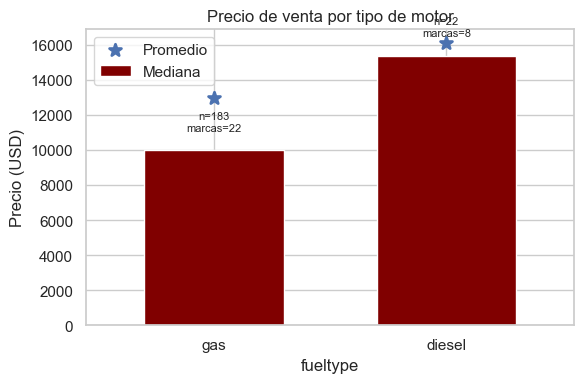


=== ANOVA: efecto de fueltype sobre price ===
                sum_sq     df         F    PR(>F)
C(fueltype)   1.265500    1.0  5.085676  0.025191
Residual     50.513717  203.0       NaN       NaN


In [41]:
mask = (
    df['CarName'].str.contains('diesel', case=False, na=False)  # busca “diesel” (sin distinguir mayúsculas)
    & (df['fueltype'] == 'gas')                                 # y fueltype es "gas"
)
df.loc[mask, 'fueltype'] = 'diesel'

fueltype = (df.groupby('fueltype')
             .agg(median=('price', 'median'),
                  mean=('price',  'mean'),
                  count=('price', 'count'),
                  brand_count=('brand', 'nunique'))
             .sort_values(by='median'))
plot_engine_price(fueltype,suffix='fueltype')
# ANOVA para evaluar si hay diferencias significativas entre grupos
df1 = df.copy()
anova_fuel = ols('logprice ~ C(fueltype)', data=df1).fit()
anova_table = sm.stats.anova_lm(anova_fuel, typ=2)

print("\n=== ANOVA: efecto de fueltype sobre price ===")
print(anova_table)
del anova_fuel, anova_table, fueltype

In [42]:
repetidos = df['CarName'].value_counts()
repetidos = repetidos[repetidos > 1]
print(repetidos)

CarName
peugeot 504                6
toyota corolla             6
toyota corona              6
subaru dl                  4
mitsubishi outlander       3
mazda 626                  3
honda civic                3
mitsubishi mirage g4       3
mitsubishi g4              3
toyota mark ii             3
nissan clipper             2
honda civic cvcc           2
honda accord               2
mazda glc                  2
mazda rx-7 gs              2
mazda glc deluxe           2
bmw x3                     2
bmw 320i                   2
audi 100ls                 2
volvo 264gl                2
volvo 144ea                2
volvo 244dl                2
toyota starlet             2
volvo 145e (sw)            2
subaru                     2
toyota corolla 1200        2
saab 99e                   2
peugeot 604sl              2
saab 99le                  2
saab 99gle                 2
nissan rogue               2
nissan latio               2
mazda rx-4                 2
isuzu D-Max                2
volksw

In [43]:
df_encoded = pd.get_dummies(df, columns=['fueltype'], drop_first=True)
df_encoded = pd.get_dummies(df_encoded, columns=['engine_class'], drop_first=True)
df_encoded.head()
print(df['enginetype'].unique())
print(df['fueltype'].unique())
print(df_encoded.columns) 

['dohc' 'ohcv' 'ohc' 'l' 'rotor' 'ohcf' 'dohcv']
['gas' 'diesel']
Index(['symboling', 'CarName', 'aspiration', 'doornumber', 'carbody',
       'drivewheel', 'enginelocation', 'wheelbase', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'enginetype', 'cylindernumber', 'enginesize',
       'fuelsystem', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'price', 'brand', 'logprice',
       'fueltype_gas', 'engine_class_performance'],
      dtype='object')


** Sabemos que dohc es la referencia

In [44]:
print(df_encoded['doornumber'].unique())

['two' 'four']


In [45]:
door_map = {
    'two': 2,
    'four': 4
}
df_encoded['doornumber'] = df_encoded['doornumber'].map(door_map)
print(df_encoded['doornumber'].unique())

[2 4]


In [46]:
# Columnas que quieres ignorar (excluir del proceso de eliminación, incluso si son object)
excluir = []

# Crear nuevo DataFrame solo con columnas numéricas o booleanas (dummies), y que no estén en 'excluir'
df_numerico = df_encoded[[col for col in df_encoded.columns 
                  if (df_encoded[col].dtype in ['int64', 'float64', 'bool']) and (col not in excluir)]]
print(df_numerico.columns)

Index(['symboling', 'doornumber', 'wheelbase', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price', 'logprice', 'fueltype_gas', 'engine_class_performance'],
      dtype='object')


In [47]:
# Valores NaN
print("Valores NaN en el DataFrame:")
print(df_numerico.isna().sum())

Valores NaN en el DataFrame:
symboling                   0
doornumber                  0
wheelbase                   0
carlength                   0
carwidth                    0
carheight                   0
curbweight                  0
enginesize                  0
boreratio                   0
stroke                      0
compressionratio            0
horsepower                  0
peakrpm                     0
citympg                     0
highwaympg                  0
price                       0
logprice                    0
fueltype_gas                0
engine_class_performance    0
dtype: int64


In [48]:
df_numerico.reset_index(inplace=True)
df_numerico.to_csv('datasets/CarPrice_Assignment_Clean.csv', index=False)
del df_numerico, df_encoded, df
gc.collect()

31

* Cargamos el archivo limpio

In [52]:
df = pd.read_csv('datasets/CarPrice_Assignment_Clean.csv', index_col='car_ID')
print("Shape: ", df.shape)
df.head()

Shape:  (205, 19)


,symboling,doornumber,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,logprice,fueltype_gas,engine_class_performance
car_ID,,,,,,,,,,,,,,,,,,,
1,3,2,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0,9.510075,True,True
2,3,2,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0,9.711116,True,True
3,1,2,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0,9.711116,True,True
4,2,4,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0,9.543235,True,False
5,2,4,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0,9.767095,True,False


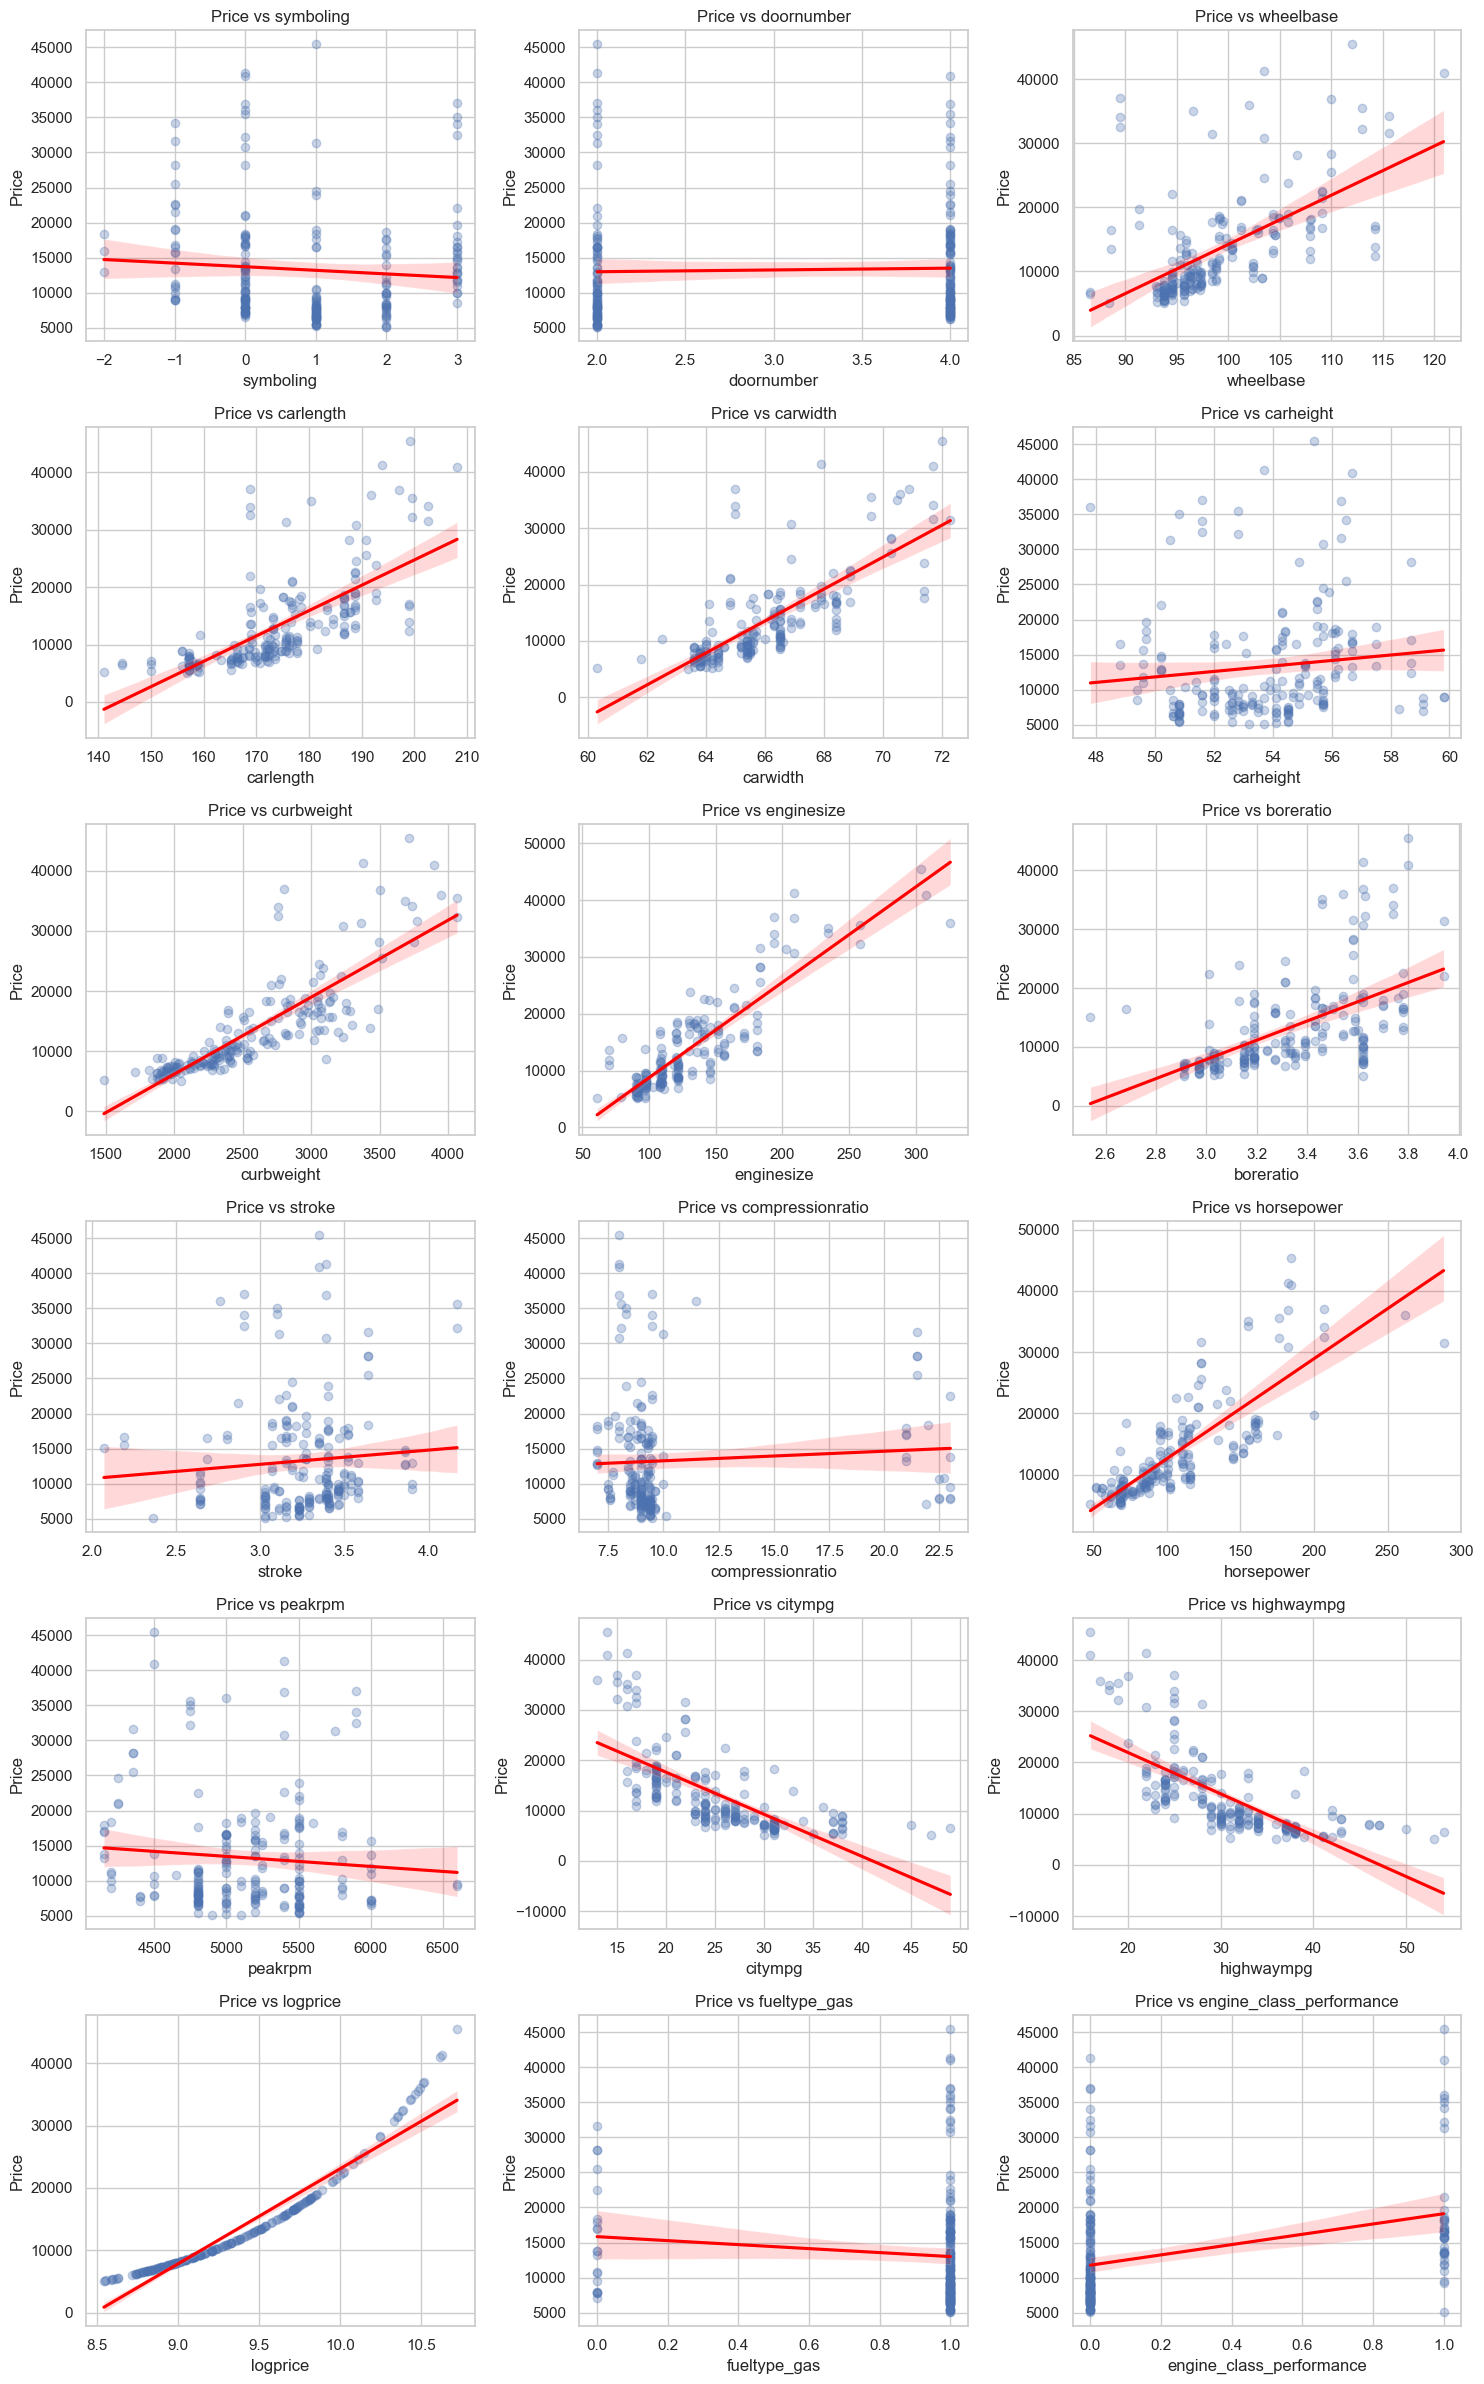

56878

In [53]:
predictoras = df.columns.drop('price')
n = len(predictoras)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, col in enumerate(predictoras, 1):
    plt.subplot(n_rows, n_cols, i)
    
    sns.regplot(data=df, x=col, y="price",
                scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
    
    plt.title(f"Price vs {col}")
    plt.xlabel(col)
    plt.ylabel("Price")

plt.tight_layout()
plt.show()

del predictoras, n, n_cols, n_rows
gc.collect()

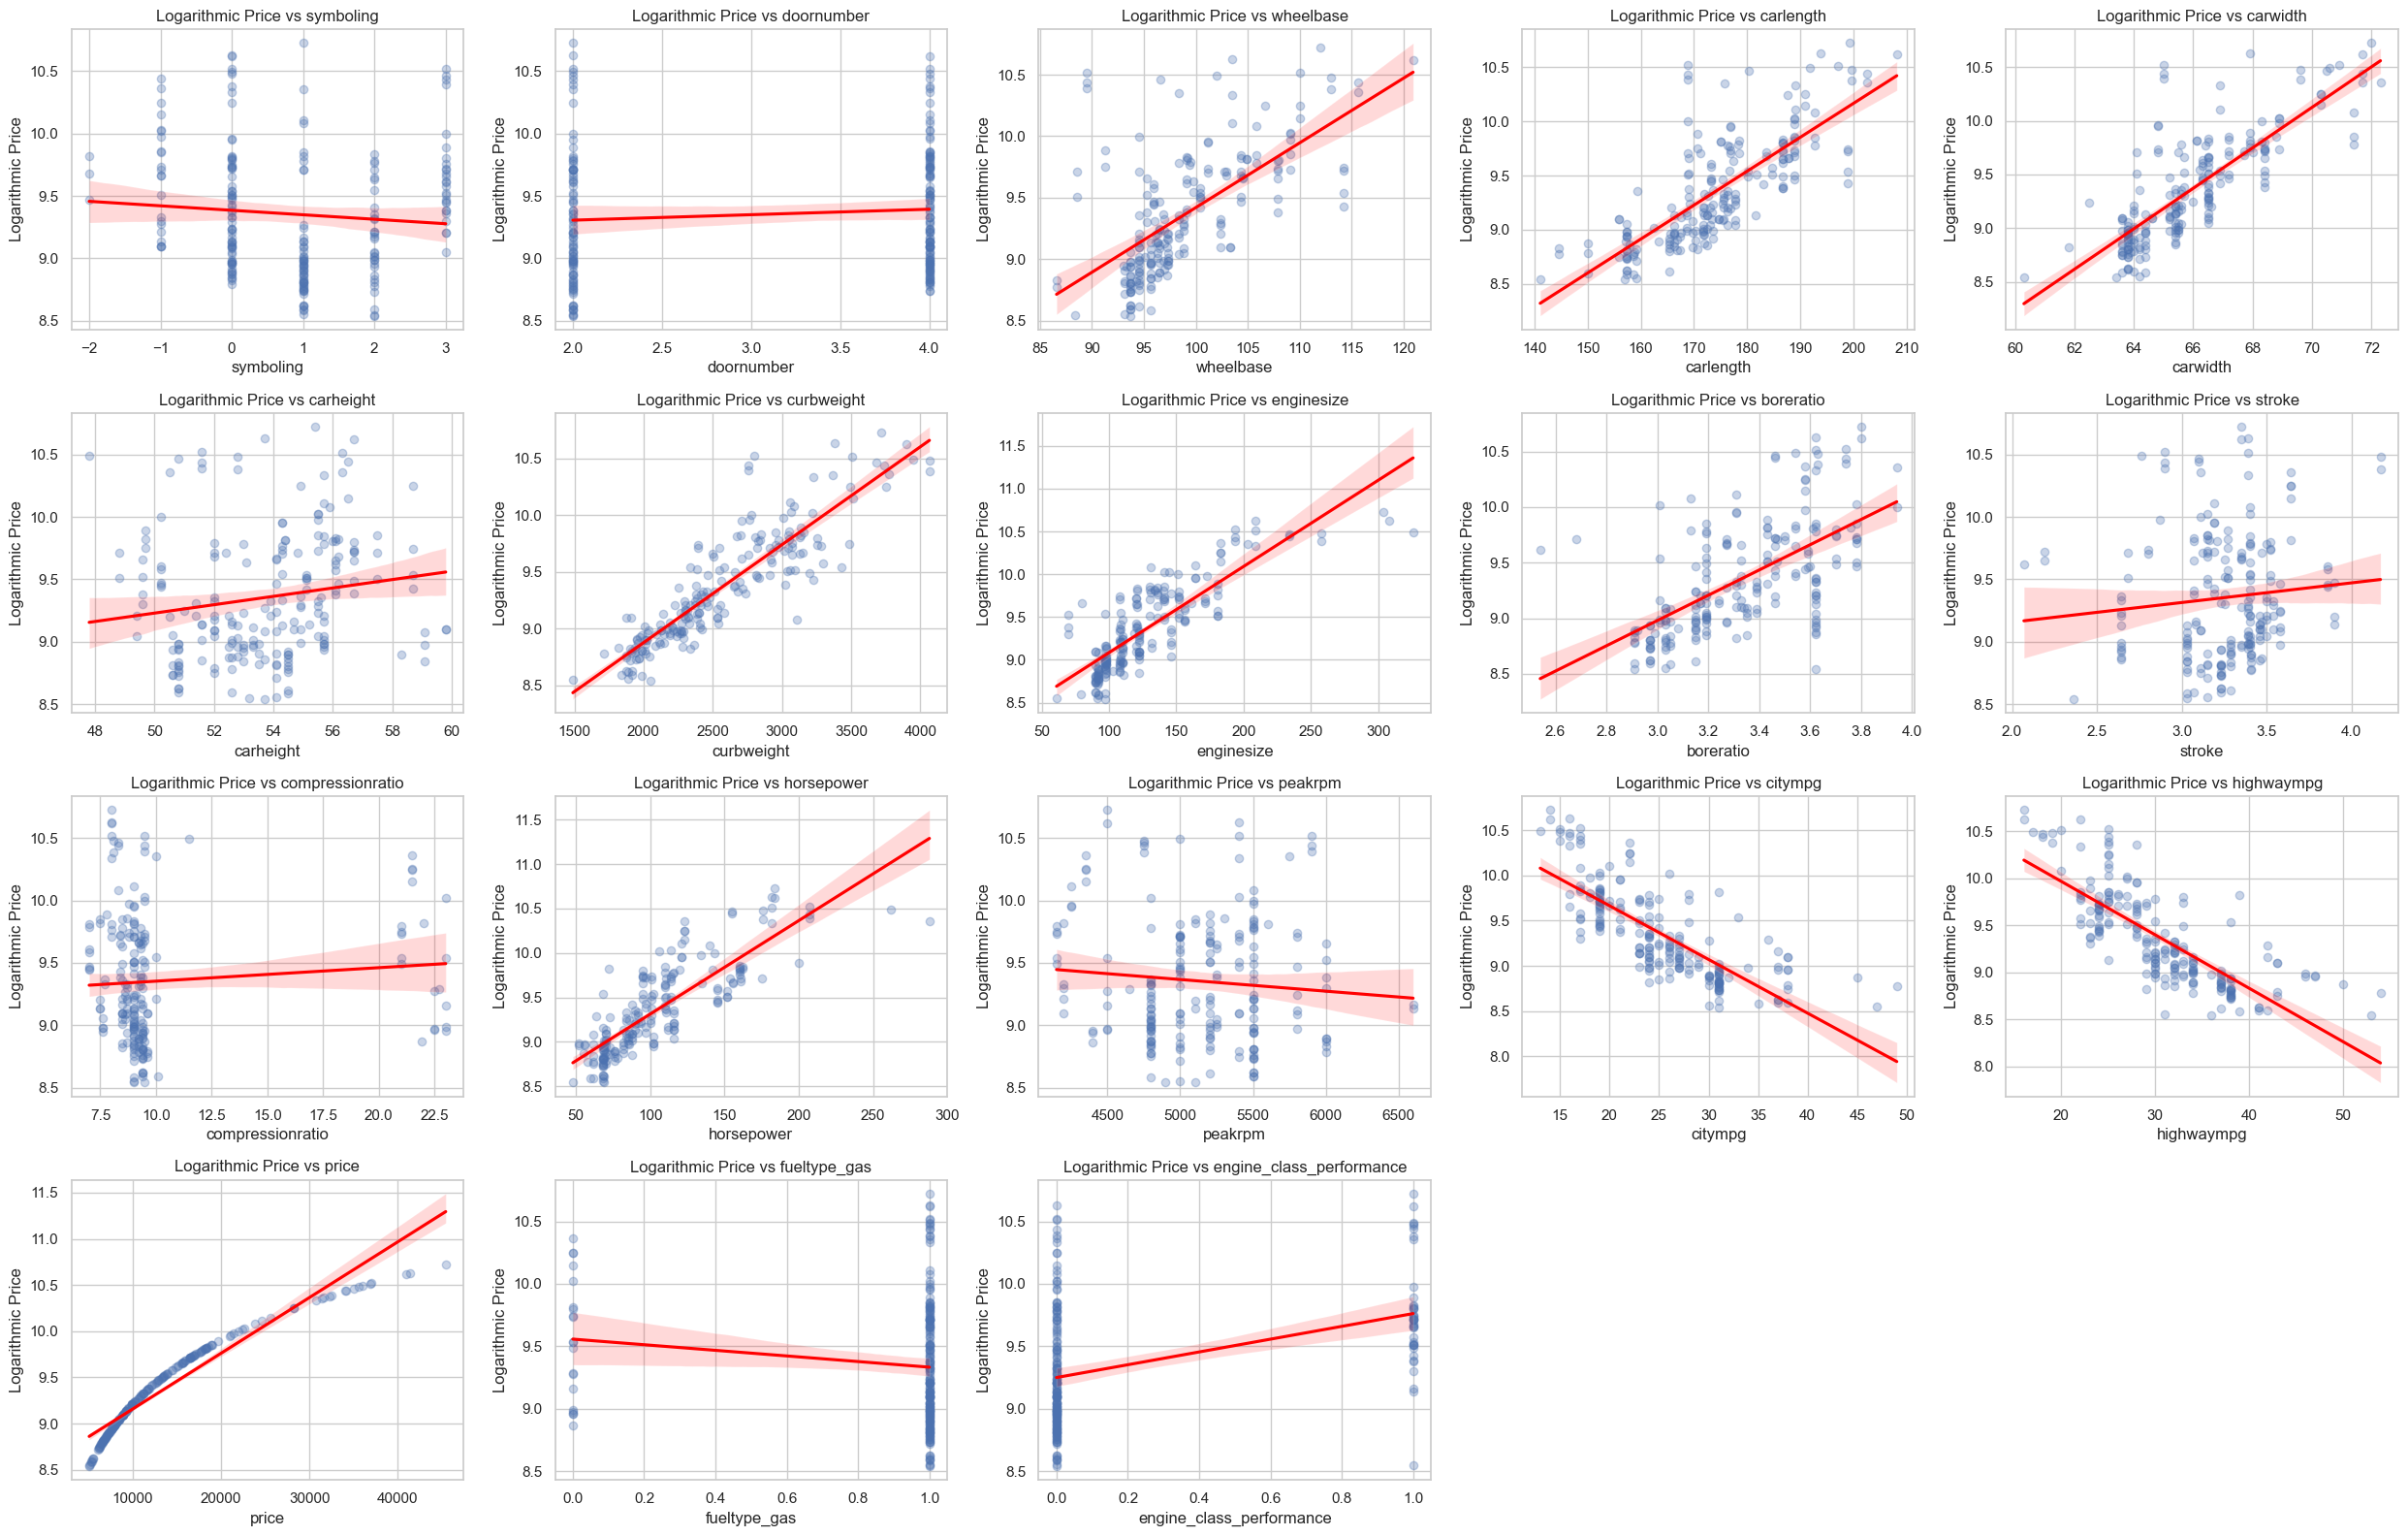

54502

In [54]:
predictoras = df.columns.drop('logprice','price')

n = len(predictoras)
n_cols = 5
n_rows = (n + n_cols - 1) // n_cols

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, col in enumerate(predictoras, 1):
    plt.subplot(n_rows, n_cols, i)
    
    sns.regplot(data=df, x=col, y="logprice",
                scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
    
    plt.title(f"Logarithmic Price vs {col}")
    plt.xlabel(col)
    plt.ylabel("Logarithmic Price")

plt.tight_layout()
plt.savefig('graficos/price_vs_predictors.png', dpi=300)
plt.show()

del predictoras, n, n_cols, n_rows
gc.collect()


=== Correlación Pearson con Price (ordenado por |valor|) ===
enginesize           |  +0.874
curbweight           |  +0.835
horsepower           |  +0.808
carwidth             |  +0.759
highwaympg           |  -0.698
citympg              |  -0.686
carlength            |  +0.683
wheelbase            |  +0.578
boreratio            |  +0.553
engine_class_performance |  +0.372
carheight            |  +0.119
fueltype_gas         |  -0.106
peakrpm              |  -0.085
symboling            |  -0.080
stroke               |  +0.079
compressionratio     |  +0.068
doornumber           |  +0.032


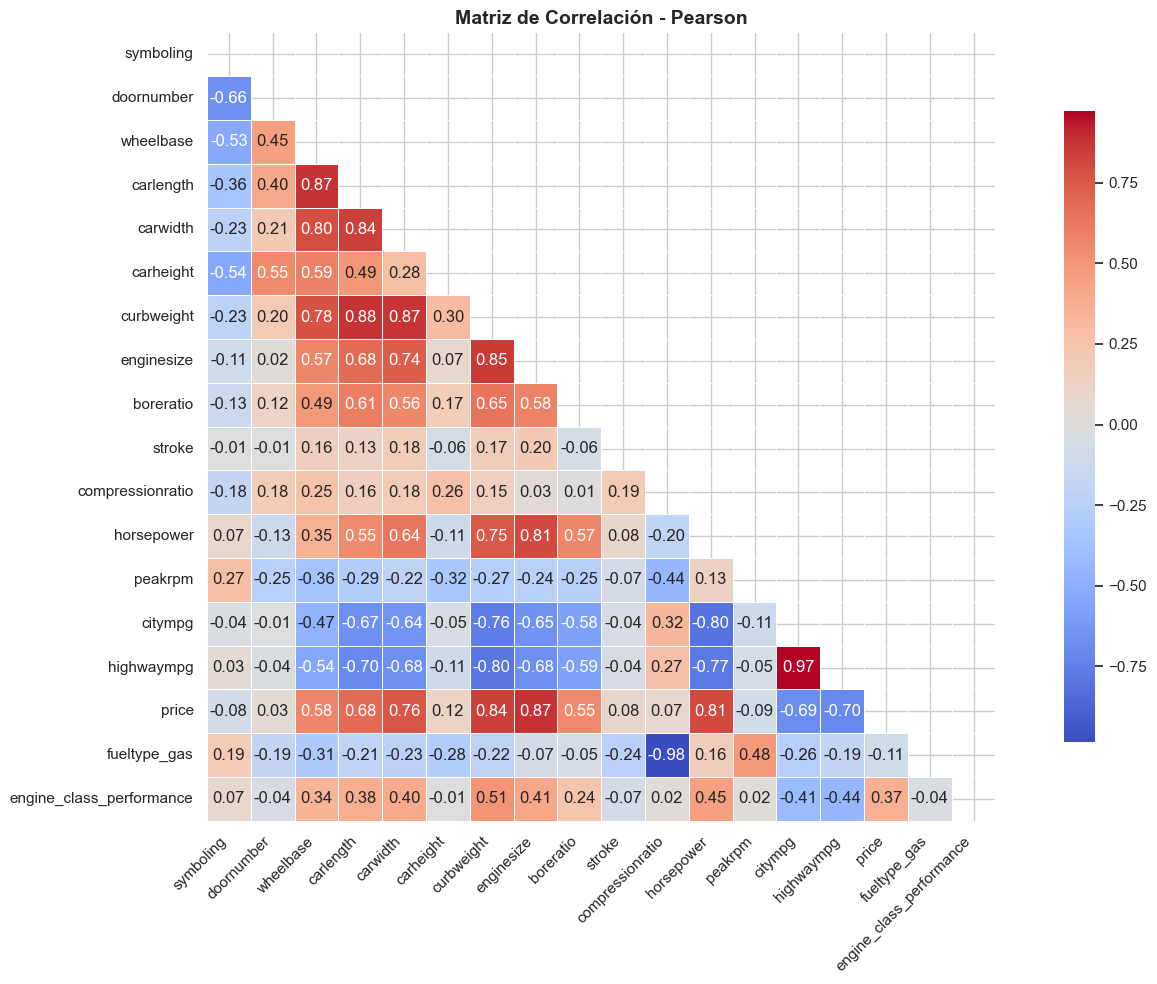


=== Correlación Kendall con Price (ordenado por |valor|) ===
curbweight           |  +0.738
horsepower           |  +0.672
citympg              |  -0.657
enginesize           |  +0.656
highwaympg           |  -0.644
carwidth             |  +0.636
carlength            |  +0.626
wheelbase            |  +0.537
boreratio            |  +0.487
engine_class_performance |  +0.345
carheight            |  +0.169
compressionratio     |  -0.134
fueltype_gas         |  -0.114
symboling            |  -0.107
doornumber           |  +0.097
stroke               |  +0.086
peakrpm              |  -0.038


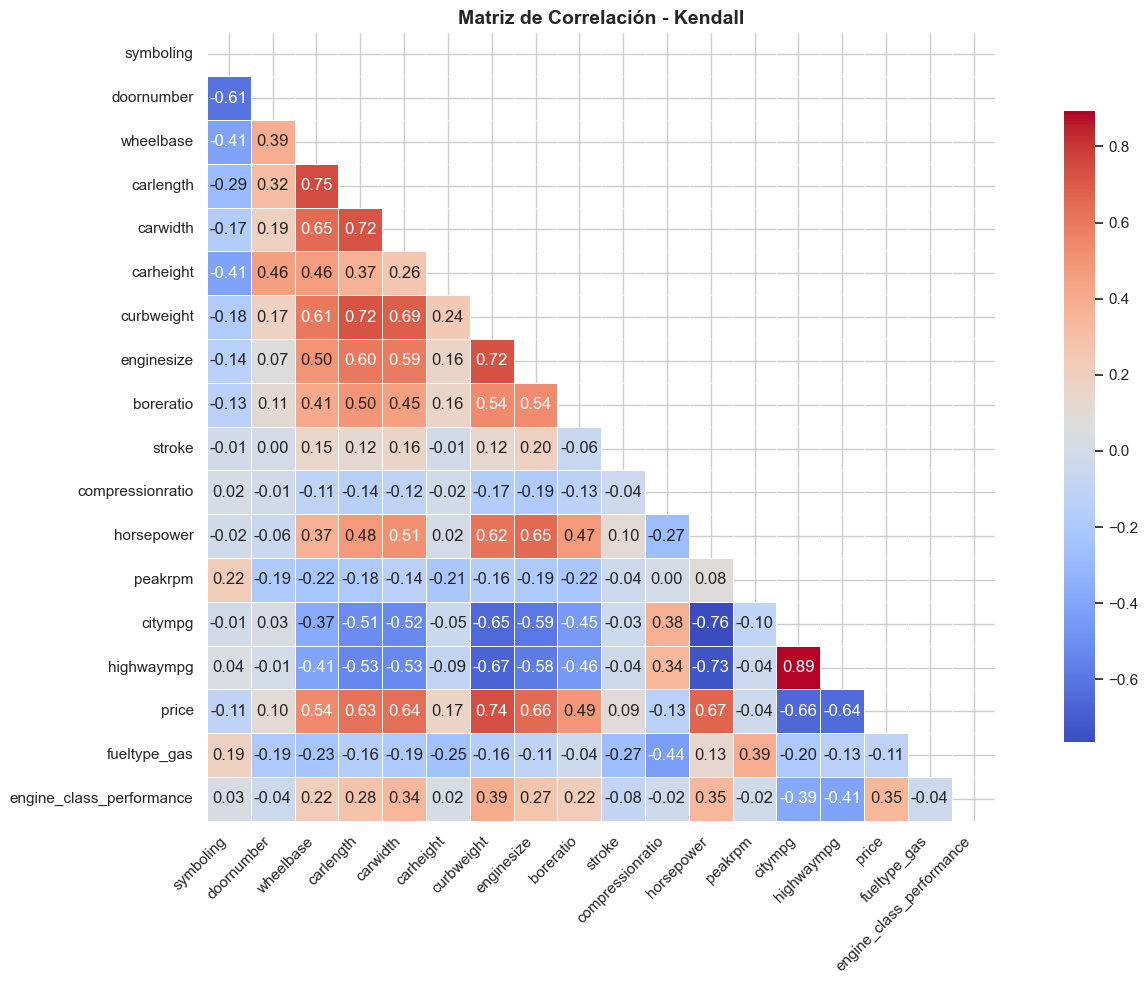


=== Correlación Spearman con Price (ordenado por |valor|) ===
curbweight           |  +0.909
horsepower           |  +0.855
citympg              |  -0.829
enginesize           |  +0.826
highwaympg           |  -0.823
carwidth             |  +0.811
carlength            |  +0.804
wheelbase            |  +0.682
boreratio            |  +0.644
engine_class_performance |  +0.422
carheight            |  +0.243
compressionratio     |  -0.174
symboling            |  -0.145
fueltype_gas         |  -0.140
doornumber           |  +0.118
stroke               |  +0.111
peakrpm              |  -0.066


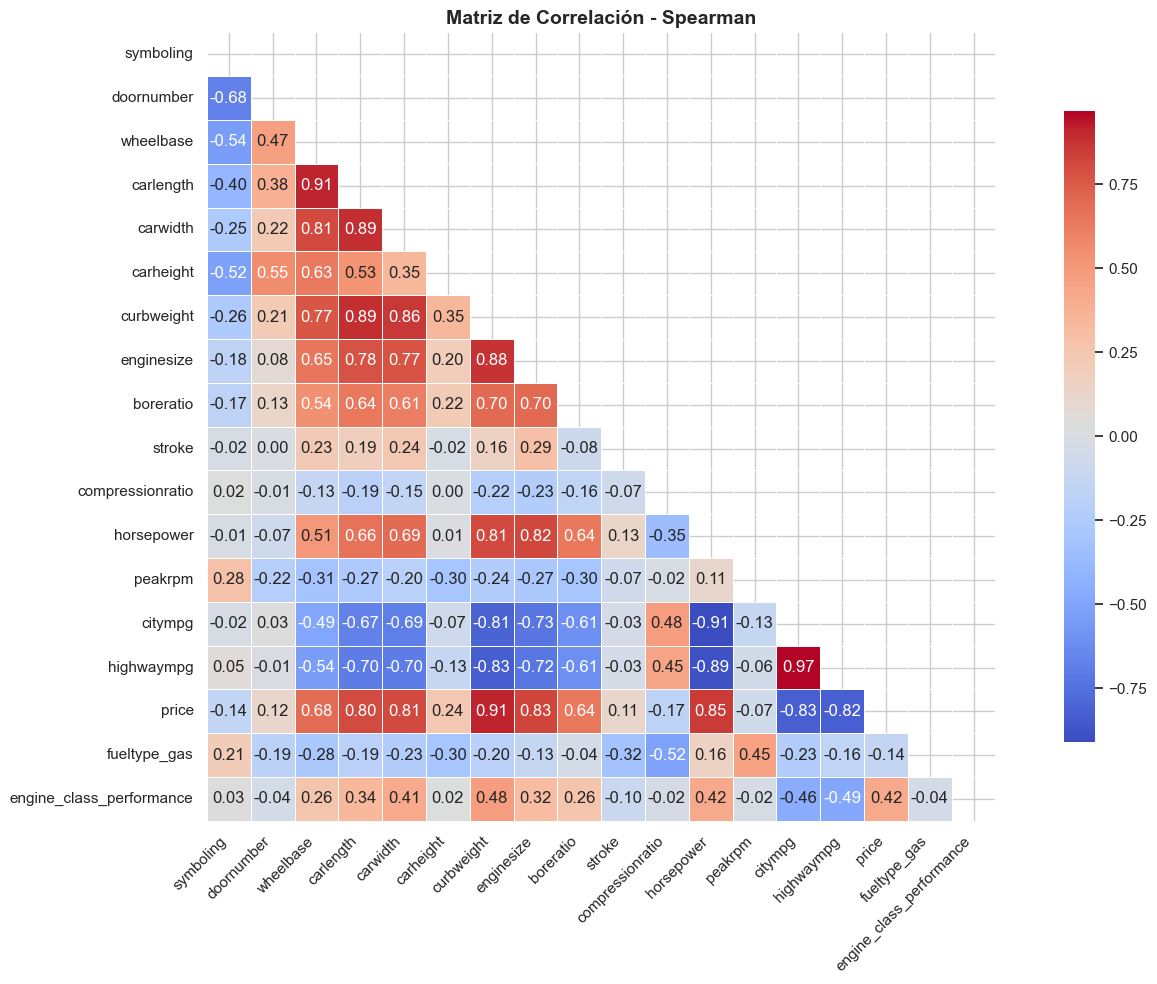

48014

In [55]:
# 1. Subconjunto (si ya estás seguro que todo es numérico puedes omitirlo)
df_corr_check = df.drop(columns='logprice').copy()

# Función para graficar heatmaps bonitos
def plot_heatmap(corr_matrix, title, figsize=(14, 10)):
    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Oculta triángulo superior
    sns.heatmap(corr_matrix, 
                mask=mask,
                annot=True, fmt=".2f", cmap="coolwarm", 
                square=True, linewidths=.5, cbar_kws={"shrink": .8})
    plt.title(title, fontsize=14, fontweight="bold")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f"graficos/heatmap_{title.replace(' ', '_').lower()}.png", dpi=300)
    plt.tight_layout()
    plt.show()
    
def print_correlaciones(df_corr, metodo):
    print(f"\n=== Correlación {metodo.title()} con Price (ordenado por |valor|) ===")
    correlaciones = df_corr['price'].drop('price')  # Evitar comparar price consigo mismo
    correlaciones_ordenadas = correlaciones.reindex(correlaciones.abs().sort_values(ascending=False).index)
    for var, val in correlaciones_ordenadas.items():
        print(f"{var:<20} |  {val:+.3f}")
# 2. Pearson
corr_pearson = df_corr_check.corr(numeric_only=True, method='pearson')
print_correlaciones(corr_pearson, 'pearson')
plot_heatmap(corr_pearson, "Matriz de Correlación - Pearson")

# 3. Kendall
corr_kendall = df_corr_check.corr(numeric_only=True, method='kendall')
print_correlaciones(corr_kendall, 'kendall')
plot_heatmap(corr_kendall, "Matriz de Correlación - Kendall")

# 4. Spearman
corr_spearman = df_corr_check.corr(numeric_only=True, method='spearman')
print_correlaciones(corr_spearman, 'spearman')
plot_heatmap(corr_spearman, "Matriz de Correlación - Spearman")

del df_corr_check, corr_pearson, corr_kendall
gc.collect()


=== Correlación Pearson con LogPrice (ordenado por |valor|) ===
curbweight           |  +0.891
enginesize           |  +0.832
horsepower           |  +0.826
carwidth             |  +0.803
highwaympg           |  -0.775
citympg              |  -0.772
carlength            |  +0.768
wheelbase            |  +0.629
boreratio            |  +0.611
engine_class_performance |  +0.411
carheight            |  +0.163
fueltype_gas         |  -0.133
stroke               |  +0.098
symboling            |  -0.089
peakrpm              |  -0.088
doornumber           |  +0.087
compressionratio     |  +0.085


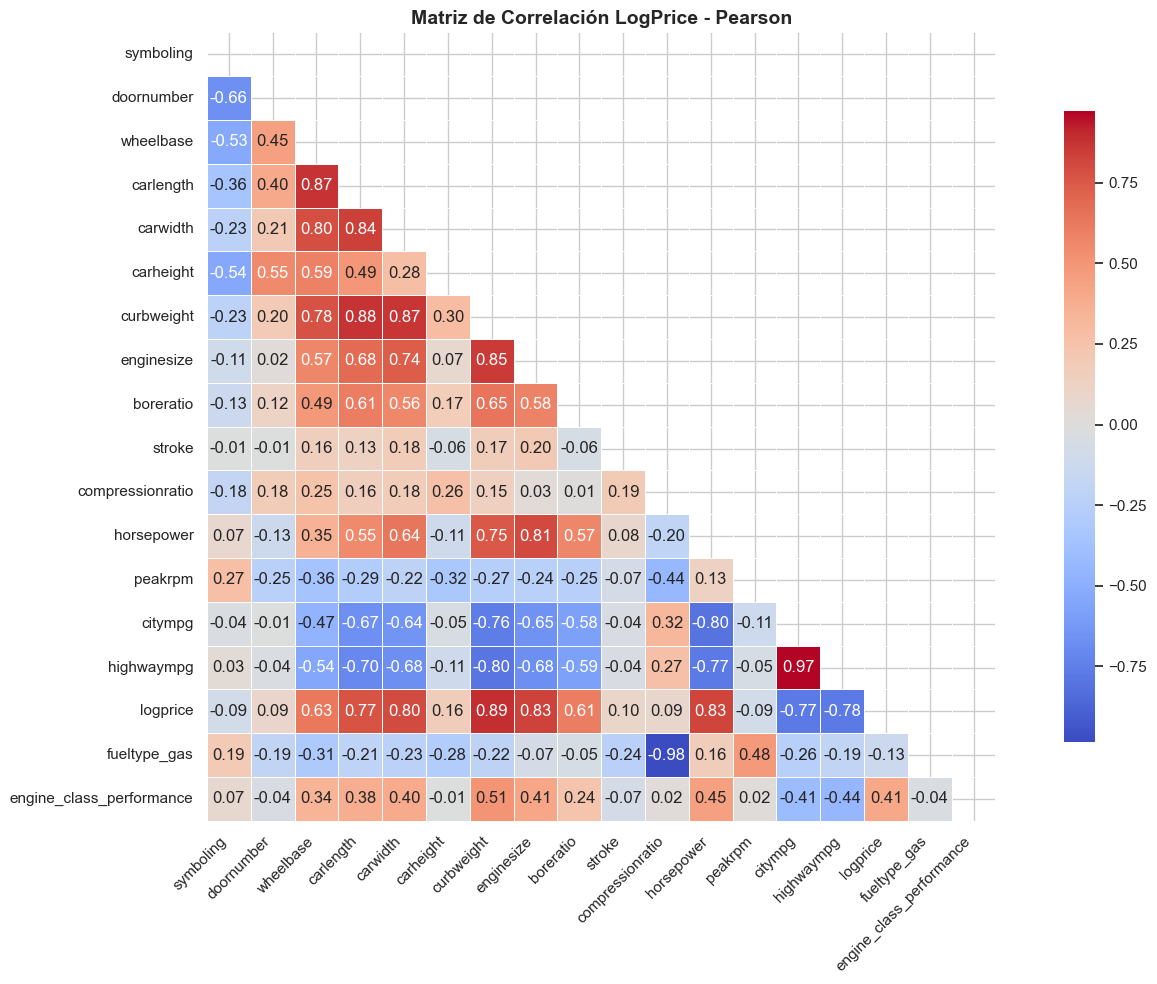


=== Correlación Kendall con LogPrice (ordenado por |valor|) ===
curbweight           |  +0.738
horsepower           |  +0.672
citympg              |  -0.657
enginesize           |  +0.656
highwaympg           |  -0.644
carwidth             |  +0.636
carlength            |  +0.626
wheelbase            |  +0.537
boreratio            |  +0.487
engine_class_performance |  +0.345
carheight            |  +0.169
compressionratio     |  -0.134
fueltype_gas         |  -0.114
symboling            |  -0.107
doornumber           |  +0.097
stroke               |  +0.086
peakrpm              |  -0.038


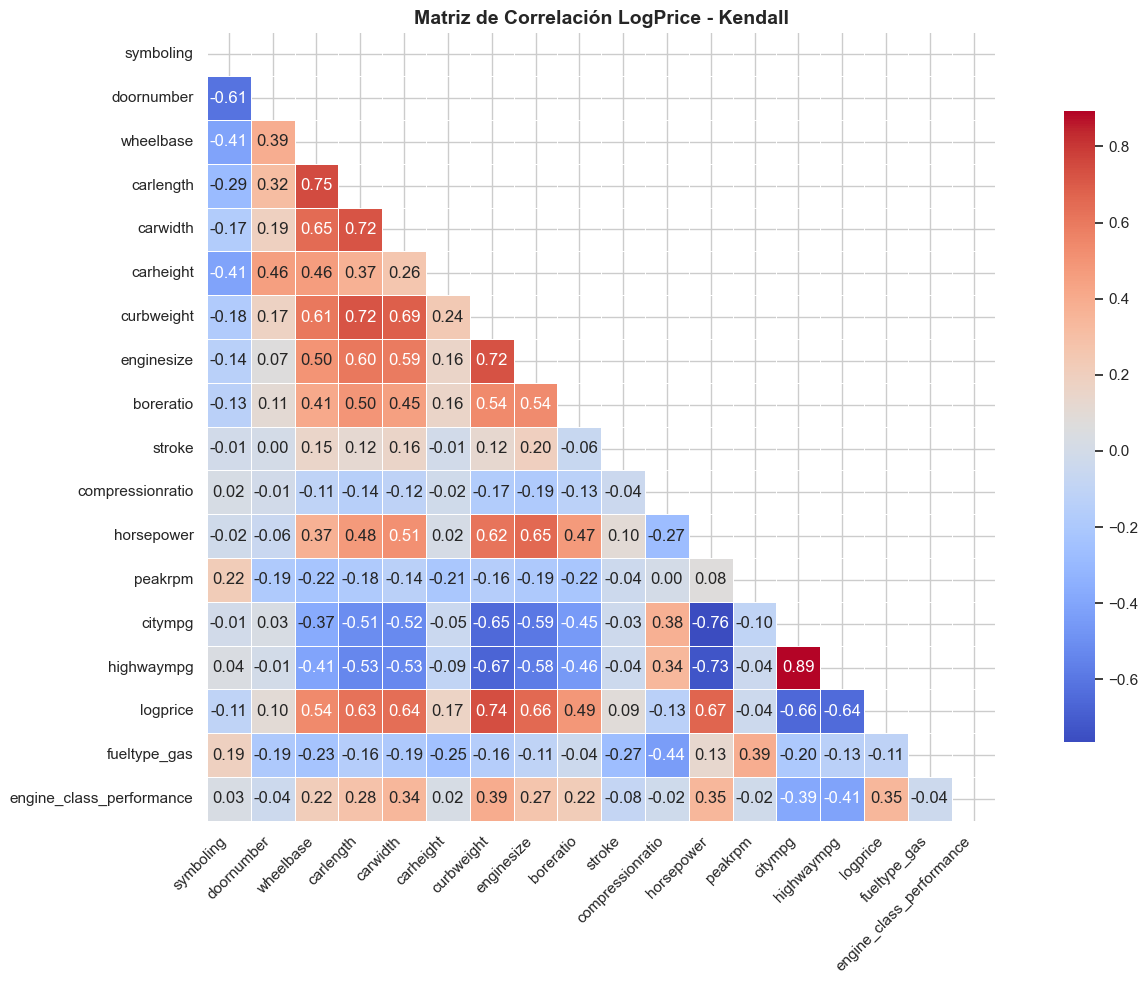


=== Correlación Spearman con LogPrice (ordenado por |valor|) ===
curbweight           |  +0.909
horsepower           |  +0.855
citympg              |  -0.829
enginesize           |  +0.826
highwaympg           |  -0.823
carwidth             |  +0.811
carlength            |  +0.804
wheelbase            |  +0.682
boreratio            |  +0.644
engine_class_performance |  +0.422
carheight            |  +0.243
compressionratio     |  -0.174
symboling            |  -0.145
fueltype_gas         |  -0.140
doornumber           |  +0.118
stroke               |  +0.111
peakrpm              |  -0.066


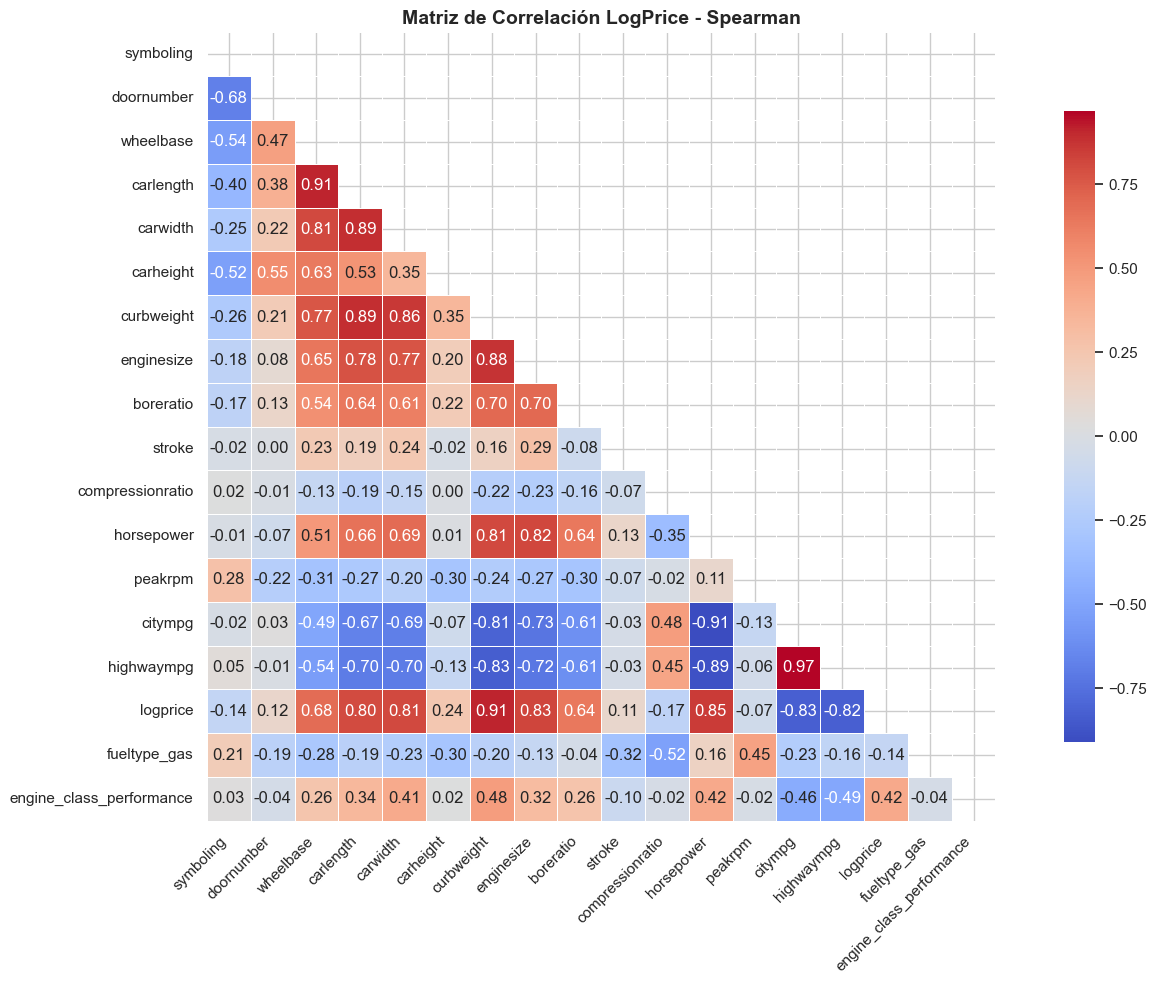

48003

In [ ]:
df_corr_check = df.drop(columns='price').copy()

def plot_heatmap(corr_matrix, title, figsize=(14, 10)):
    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Oculta triángulo superior
    sns.heatmap(corr_matrix, 
                mask=mask,
                annot=True, fmt=".2f", cmap="coolwarm", 
                square=True, linewidths=.5, cbar_kws={"shrink": .8})
    plt.title(title, fontsize=14, fontweight="bold")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f"graficos/heatmap_{title.replace(' ', '_').lower()}.png", dpi=300)
    plt.tight_layout()
    plt.show()
    
def print_correlaciones(df_corr, metodo):
    print(f"\n=== Correlación {metodo.title()} con LogPrice (ordenado por |valor|) ===")
    correlaciones = df_corr['logprice'].drop('logprice')  # Evitar comparar price consigo mismo
    correlaciones_ordenadas = correlaciones.reindex(correlaciones.abs().sort_values(ascending=False).index)
    for var, val in correlaciones_ordenadas.items():
        print(f"{var:<20} |  {val:+.3f}")
# 2. Pearson
corr_pearson = df_corr_check.corr(numeric_only=True, method='pearson')
print_correlaciones(corr_pearson, 'pearson')
plot_heatmap(corr_pearson, "Matriz de Correlación LogPrice - Pearson")

# 3. Kendall
corr_kendall = df_corr_check.corr(numeric_only=True, method='kendall')
print_correlaciones(corr_kendall, 'kendall')
plot_heatmap(corr_kendall, "Matriz de Correlación LogPrice - Kendall")

# 4. Spearman
corr_spearman = df_corr_check.corr(numeric_only=True, method='spearman')
print_correlaciones(corr_spearman, 'spearman')
plot_heatmap(corr_spearman, "Matriz de Correlación LogPrice - Spearman")


del df_corr_check, corr_pearson, corr_kendall
gc.collect()

C:\Users\diego\AppData\Local\Temp\ipykernel_6908\2108110040.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Variable', y='Valor', data=df_melt, palette='Set2')
C:\Users\diego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\diego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\diego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-p

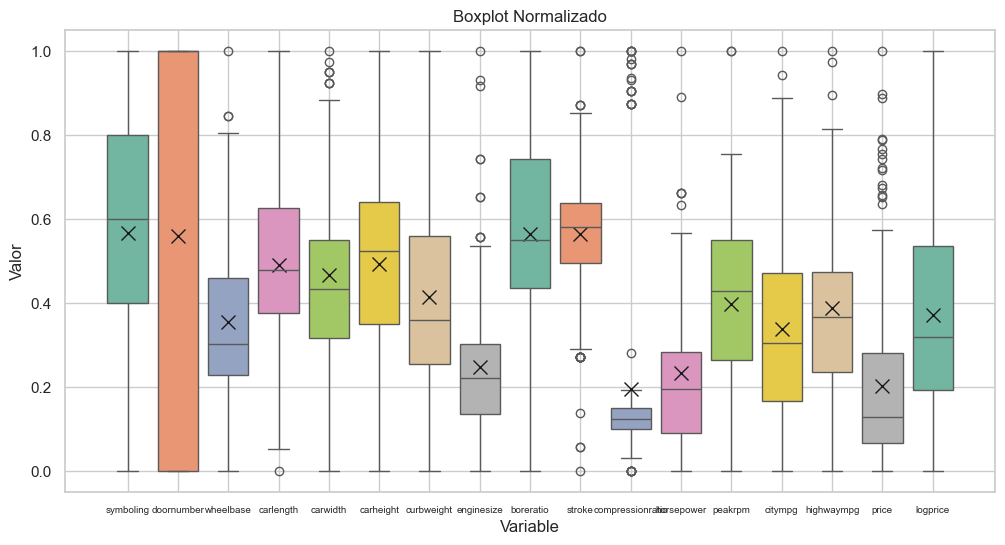

In [57]:
from sklearn.preprocessing import MinMaxScaler

# Normalización
df_scaled = df.drop(columns=['engine_class_performance','fueltype_gas']).copy()

# 2. Normalización
scaler = MinMaxScaler()
df_scaled[df_scaled.columns] = scaler.fit_transform(df_scaled)

# 3. Melt para boxplot
df_melt = df_scaled.melt(var_name='Variable', value_name='Valor')

# 4. Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Variable', y='Valor', data=df_melt, palette='Set2')

# 5. Medias reales escaladas
for i, var in enumerate(df_scaled.columns):
    media = df[var].mean()
    media_scaled = scaler.transform([[media if c == var else df[c].mean() for c in df_scaled.columns]])[0][i]
    plt.plot(i, media_scaled, 'kx', markersize=10)
plt.xticks(fontsize=7)
plt.title("Boxplot Normalizado")
plt.grid(True)
plt.savefig("graficos/boxplot_normalizado.png", dpi=300)
plt.show()

In [19]:
from plotly import graph_objects as go
n = len(df.columns)
# Determinar cantidad de filas y columnas para la grilla
n_cols = 4
n_rows = (n + 1) // n_cols

fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=df.columns.tolist())
# Agregar cada histograma
for i, col in enumerate(df.columns):
    data_col = df[col].dropna()
    bins_sturges = int(np.ceil(np.log2(len(data_col)) + 1))

    row = i // n_cols + 1
    col_pos = i % n_cols + 1
    fig.add_trace(go.Histogram(x=data_col, nbinsx=bins_sturges, name=col), row=row, col=col_pos)

fig.update_layout(title_text='Histogramas de las variables',
                  height=300 * n_rows,
                  showlegend=False)
fig.show()

Ahora seguiremos en R